# Regression Model for [PROJECT NAME] Using Python version 14
### David Lowe
### July 8, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. The [PROJECT NAME] dataset is a regression situation where we are trying to predict the value of a continuous variable.

INTRODUCTION: [Sample Paragraph - The dataset for this project originates from the UCI Machine Learning Repository. The Boston housing data was collected in 1978 and each of the 506 entries represent aggregated data about 14 features for homes from various suburbs in Boston, Massachusetts.]

ANALYSIS: [Sample Paragraph - The baseline performance of the machine learning algorithms achieved an average RMSE of 5.20. Two algorithms (Extra Trees and Gradient Boosting) achieved the top RMSE metrics after the first round of modeling. After a series of tuning trials, Gradient Boosting turned a better overall result than Extra Trees. Gradient Boosting achieved an RMSE metric of 3.65. By using the optimized parameters, the Gradient Boosting model processed the test dataset with an RMSE of 2.38, which was even better than the prediction from the training data.]

CONCLUSION: [Sample Paragraph - For this iteration, the Gradient Boosting model achieved the best overall results using the training and testing datasets. For this dataset, Gradient Boosting should be considered for further modeling.]

Dataset Used: [PROJECT NAME] Data Set

Dataset ML Model: Regression with [numerical | categorical] attributes

Dataset Reference: [https://archive.ics.uci.edu/ml/datasets/housing]

One potential source of performance benchmarks: [https://www.kaggle.com/c/boston-housing]

Any predictive modeling machine learning project generally can be broken down into about six major tasks:

1. Prepare Environment
2. Summarize and Visualize Data
3. Pre-process Data
4. Train and Evaluate Models
5. Fine-tune and Improve Models
6. Finalize Model and Present Analysis

## Task 1 - Prepare Environment

In [1]:
# Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL

In [2]:
# Retrieve the GPU information from Colab
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#     print('and then re-execute this cell.')
# else:
#     print(gpu_info)

In [3]:
# Retrieve the memory configuration from Colab
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# if ram_gb < 20:
#     print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
#     print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
#     print('re-execute this cell.')
# else:
#     print('You are using a high-RAM runtime!')

In [4]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 4


### 1.a) Load libraries and modules

In [5]:
# Set the random seed number for reproducible results
seedNum = 888

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import math
import smtplib
import boto3
from datetime import datetime
from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# from sklearn.pipeline import Pipeline
# from sklearn.feature_selection import RFE
# from imblearn.over_sampling import SMOTE
# from imblearn.combine import SMOTEENN
# from imblearn.combine import SMOTETomek

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
# from xgboost import XGBRegressor

### 1.b) Set up the controlling parameters and functions

In [7]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = True

# Set up the parent directory location for loading the dotenv files
useColab = False
if useColab:
    # Mount Google Drive locally for storing files
    from google.colab import drive
    drive.mount('/content/gdrive')
    gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
    env_path = '/content/gdrive/My Drive/Colab Notebooks/'
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
useLocalPC = False
if useLocalPC:
    env_path = "/Users/david/PycharmProjects/"
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Configure the plotting style
plt.style.use('seaborn')

# Set Pandas options
pd.set_option("display.max_rows", 500)
pd.set_option("display.width", 140)

# Set the flag for splitting the dataset
splitDataset = True
splitPercentage = 0.25

# Set the number of folds for cross validation
n_folds = 5

# Set various default modeling parameters
scoring = 'neg_mean_squared_error'

In [8]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = "arn:aws:sns:us-east-1:072417399597:PythonMLScriptNotification"
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [9]:
if notifyStatus: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [10]:
dataset_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data'
colNames = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','targetVar']
Xy_original = pd.read_csv(dataset_path, delim_whitespace=True, names=colNames, header=None, index_col=False)

# Take a peek at the dataframe after import
Xy_original.head(10)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,targetVar
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222.0,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311.0,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311.0,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311.0,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311.0,15.2,386.71,17.10,18.9


In [11]:
Xy_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   CRIM       506 non-null    float64
 1   ZN         506 non-null    float64
 2   INDUS      506 non-null    float64
 3   CHAS       506 non-null    int64  
 4   NOX        506 non-null    float64
 5   RM         506 non-null    float64
 6   AGE        506 non-null    float64
 7   DIS        506 non-null    float64
 8   RAD        506 non-null    int64  
 9   TAX        506 non-null    float64
 10  PTRATIO    506 non-null    float64
 11  B          506 non-null    float64
 12  LSTAT      506 non-null    float64
 13  targetVar  506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [12]:
Xy_original.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,targetVar
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [13]:
Xy_original.isnull().sum()

CRIM         0
ZN           0
INDUS        0
CHAS         0
NOX          0
RM           0
AGE          0
DIS          0
RAD          0
TAX          0
PTRATIO      0
B            0
LSTAT        0
targetVar    0
dtype: int64

In [14]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  0


### 1.d) Data Cleaning

In [15]:
# Standardize the class column to the name of targetVar if required
# Xy_original = Xy_original.rename(columns={'old_name': 'targetVar'})

# Dropping features
# Xy_original.drop(columns=['column1','column2','column3'], inplace=True)

# Impute missing values
# Xy_original['col_name'].fillna('someValue', inplace=True)
# Xy_original['col_name'].fillna(value=Xy_original['col_name'].median(), inplace=True)

# Convert columns from one data type to another
# Xy_original.column_name = Xy_original.column_name.astype('int')
# Xy_original.column_name = Xy_original.column_name.astype('category')
Xy_original.CHAS = Xy_original.CHAS.astype('float')
Xy_original.RAD = Xy_original.RAD.astype('float')

# Convert features with 1/0 levels into categorical feature of Y/N
# def reclass_somecol(code):
#     if code == 1: return 'Y'
#     else: return 'N'
# Xy_original['targetVar] = Xy_original['targetVar'].apply(reclass_somecol)

# Take a peek at the dataframe after cleaning
Xy_original.head(10)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,targetVar
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,5.0,311.0,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0.0,0.524,6.172,96.1,5.9505,5.0,311.0,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0.0,0.524,6.004,85.9,6.5921,5.0,311.0,15.2,386.71,17.10,18.9


In [16]:
Xy_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   CRIM       506 non-null    float64
 1   ZN         506 non-null    float64
 2   INDUS      506 non-null    float64
 3   CHAS       506 non-null    float64
 4   NOX        506 non-null    float64
 5   RM         506 non-null    float64
 6   AGE        506 non-null    float64
 7   DIS        506 non-null    float64
 8   RAD        506 non-null    float64
 9   TAX        506 non-null    float64
 10  PTRATIO    506 non-null    float64
 11  B          506 non-null    float64
 12  LSTAT      506 non-null    float64
 13  targetVar  506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


In [17]:
Xy_original.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,targetVar
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [18]:
Xy_original.isnull().sum()

CRIM         0
ZN           0
INDUS        0
CHAS         0
NOX          0
RM           0
AGE          0
DIS          0
RAD          0
TAX          0
PTRATIO      0
B            0
LSTAT        0
targetVar    0
dtype: int64

In [19]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  0


### 1.e) Splitting Data into Attribute-only and Target-only Sets

In [20]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = totCol

In [21]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_original = Xy_original.iloc[:,0:totAttr]
    y_original = Xy_original.iloc[:,totAttr]
else:
    X_original = Xy_original.iloc[:,1:totCol]
    y_original = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_original.shape: {} y_original.shape: {}".format(Xy_original.shape, X_original.shape, y_original.shape))

Xy_original.shape: (506, 14) X_original.shape: (506, 13) y_original.shape: (506,)


### 1.f) Set up the parameters for data visualization

In [22]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
plt.rcParams["figure.figsize"] = fig_size

In [23]:
if notifyStatus: status_notify("Task 1 - Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [24]:
if notifyStatus: status_notify("Task 2 - Summarize and Visualize Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 2.a) Descriptive Statistics

#### 2.a.i) Peek at the attribute columns

In [25]:
X_original.head(10)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,5.21
6,0.08829,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,5.0,311.0,15.2,395.60,12.43
7,0.14455,12.5,7.87,0.0,0.524,6.172,96.1,5.9505,5.0,311.0,15.2,396.90,19.15
8,0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93
9,0.17004,12.5,7.87,0.0,0.524,6.004,85.9,6.5921,5.0,311.0,15.2,386.71,17.10


#### 2.a.ii) Dimensions and attribute types

In [26]:
X_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
dtypes: float64(13)
memory usage: 51.5 KB


#### 2.a.iii) Statistical summary of the attributes

In [27]:
X_original.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


### 2.b) Data Visualization

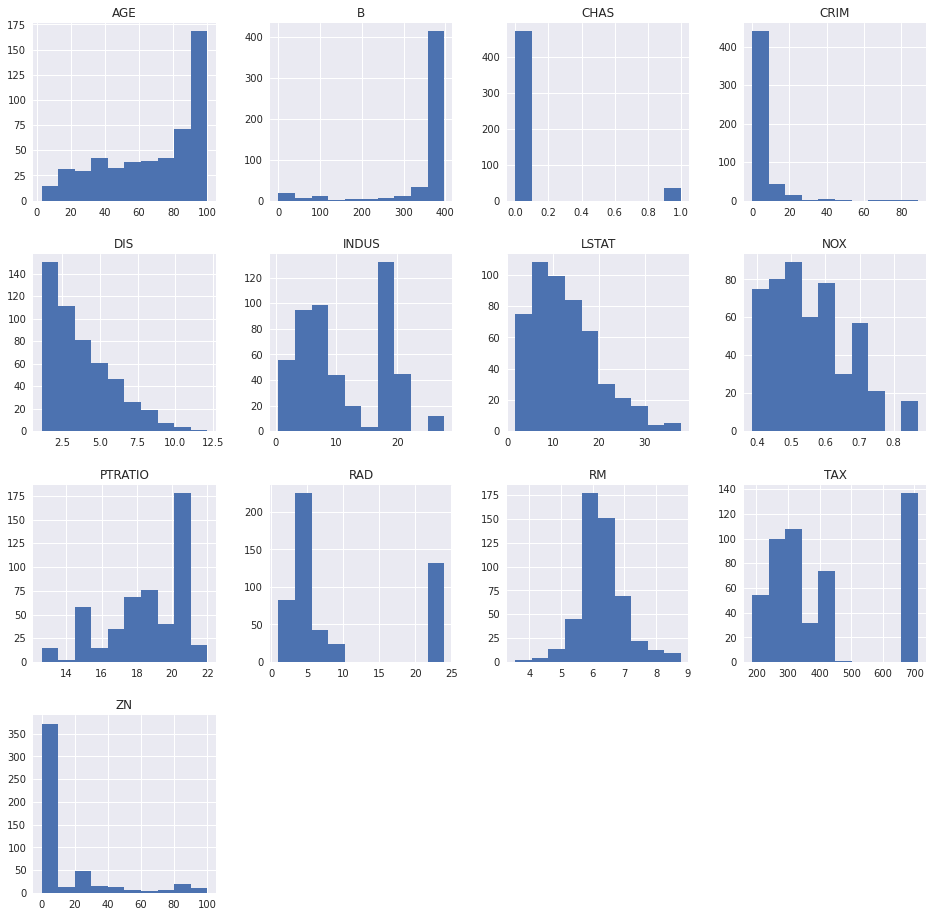

In [28]:
# Histograms for each attribute
X_original.hist(layout=(dispRow,dispCol))
plt.show()

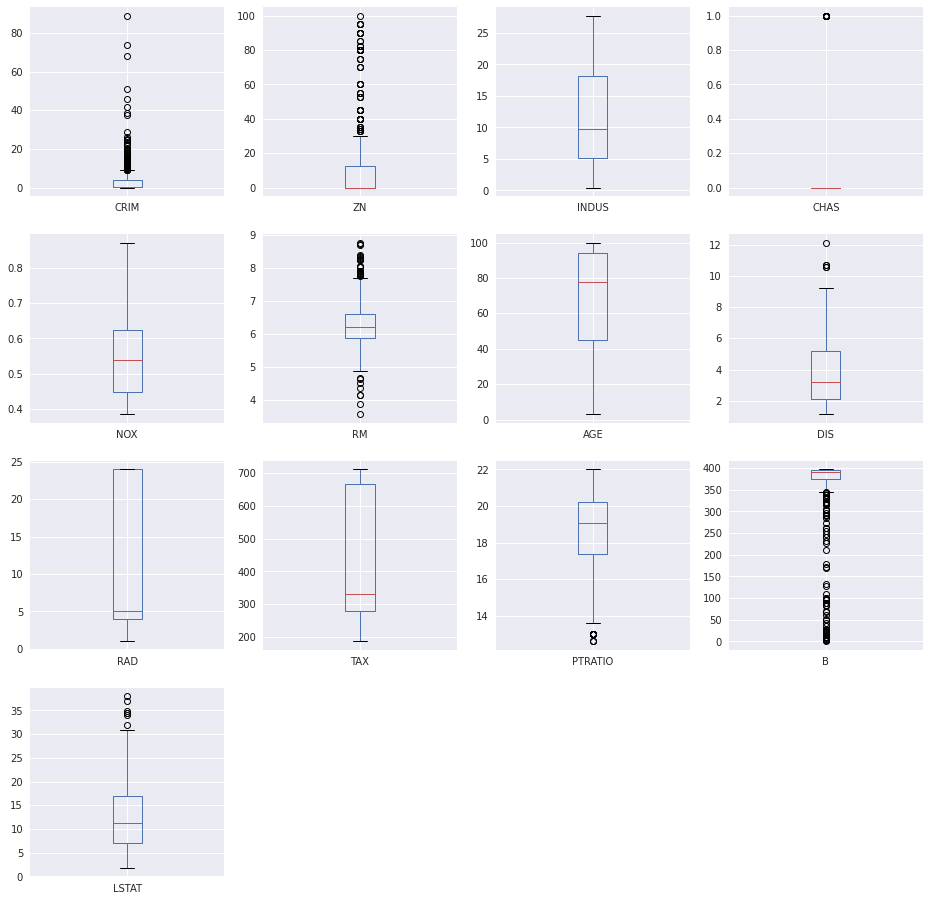

In [29]:
# Box and Whisker plot for each attribute
X_original.plot(kind='box', subplots=True, layout=(dispRow,dispCol))
plt.show()

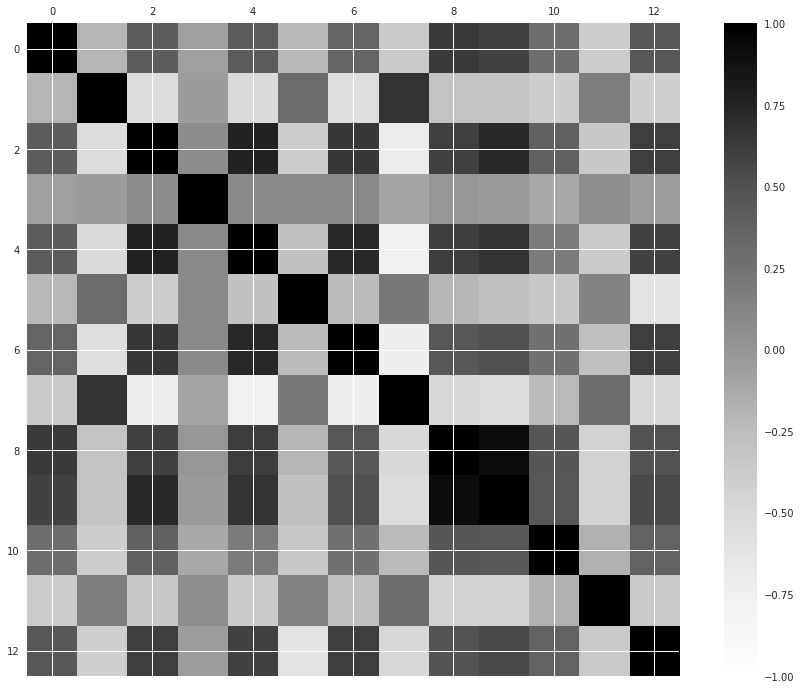

In [30]:
# Correlation matrix
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)
correlations = X_original.corr(method='pearson')
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
plt.show()

In [31]:
if notifyStatus: status_notify("Task 2 - Summarize and Visualize Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [32]:
if notifyStatus: status_notify("Task 3 - Pre-process Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Splitting Data into Training and Test Sets

In [33]:
# Not applicable for this iteration of the project
# Perform one-hot-encoding on the categorical attributes
# X_original = pd.get_dummies(X_original)
# print(X_original.info())

In [34]:
# Split the data further into training and test datasets
if splitDataset:
    X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_original, y_original, test_size=splitPercentage, random_state=seedNum)
else:
    X_train_df, y_train_df = X_original, y_original
    X_test_df, y_test_df = X_original, y_original
print("X_train_df.shape: {} y_train_df.shape: {}".format(X_train_df.shape, y_train_df.shape))
print("X_test_df.shape: {} y_test_df.shape: {}".format(X_test_df.shape, y_test_df.shape))

X_train_df.shape: (379, 13) y_train_df.shape: (379,)
X_test_df.shape: (127, 13) y_test_df.shape: (127,)


### 3.b) Feature Scaling and Data Pre-Processing

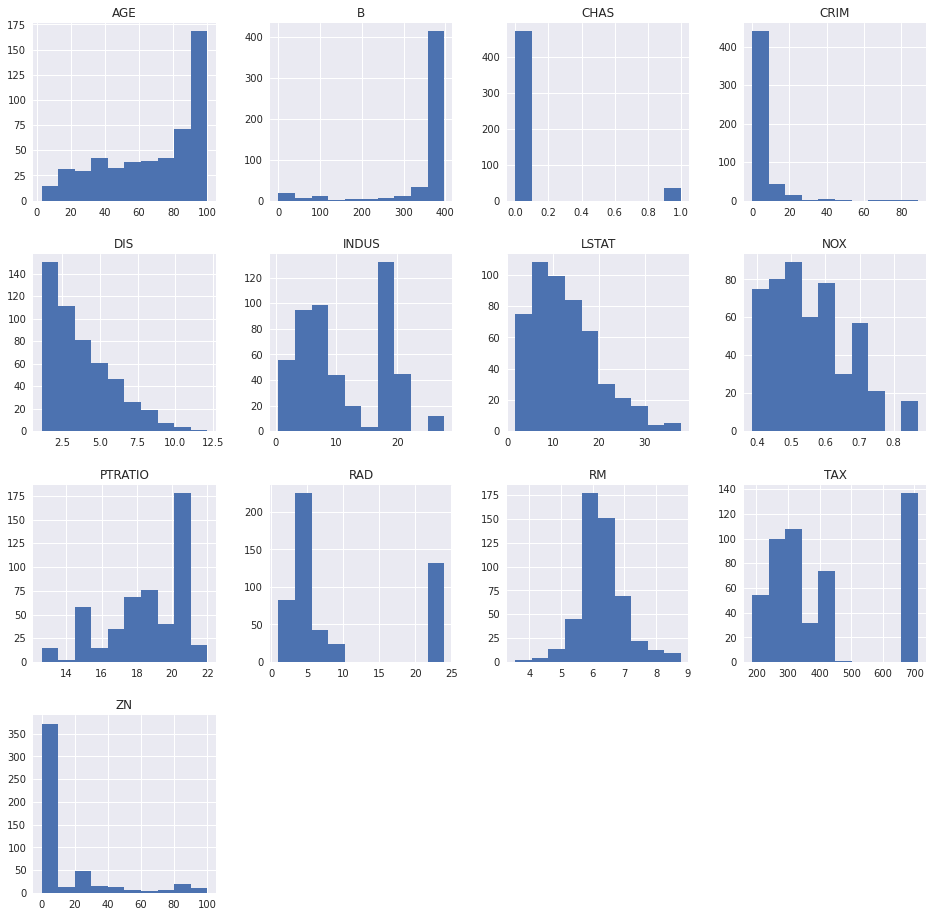

In [35]:
# Histograms for each attribute before pre-processing
columns_to_scale = X_original.columns[X_original.dtypes == 'float64'].tolist()
X_original[columns_to_scale].hist(layout=(dispRow,dispCol))
plt.show()

In [36]:
# Apply feature scaling and transformation
print('Columns to scale are:', columns_to_scale)
scaler = preprocessing.StandardScaler()
X_original[columns_to_scale] = scaler.fit_transform(X_original[columns_to_scale])
print(X_original.head())

Columns to scale are: ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
       CRIM        ZN     INDUS      CHAS       NOX        RM       AGE       DIS       RAD       TAX   PTRATIO         B     LSTAT
0 -0.419782  0.284830 -1.287909 -0.272599 -0.144217  0.413672 -0.120013  0.140214 -0.982843 -0.666608 -1.459000  0.441052 -1.075562
1 -0.417339 -0.487722 -0.593381 -0.272599 -0.740262  0.194274  0.367166  0.557160 -0.867883 -0.987329 -0.303094  0.441052 -0.492439
2 -0.417342 -0.487722 -0.593381 -0.272599 -0.740262  1.282714 -0.265812  0.557160 -0.867883 -0.987329 -0.303094  0.396427 -1.208727
3 -0.416750 -0.487722 -1.306878 -0.272599 -0.835284  1.016303 -0.809889  1.077737 -0.752922 -1.106115  0.113032  0.416163 -1.361517
4 -0.412482 -0.487722 -1.306878 -0.272599 -0.835284  1.228577 -0.511180  1.077737 -0.752922 -1.106115  0.113032  0.441052 -1.026501


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:2969: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:2935: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

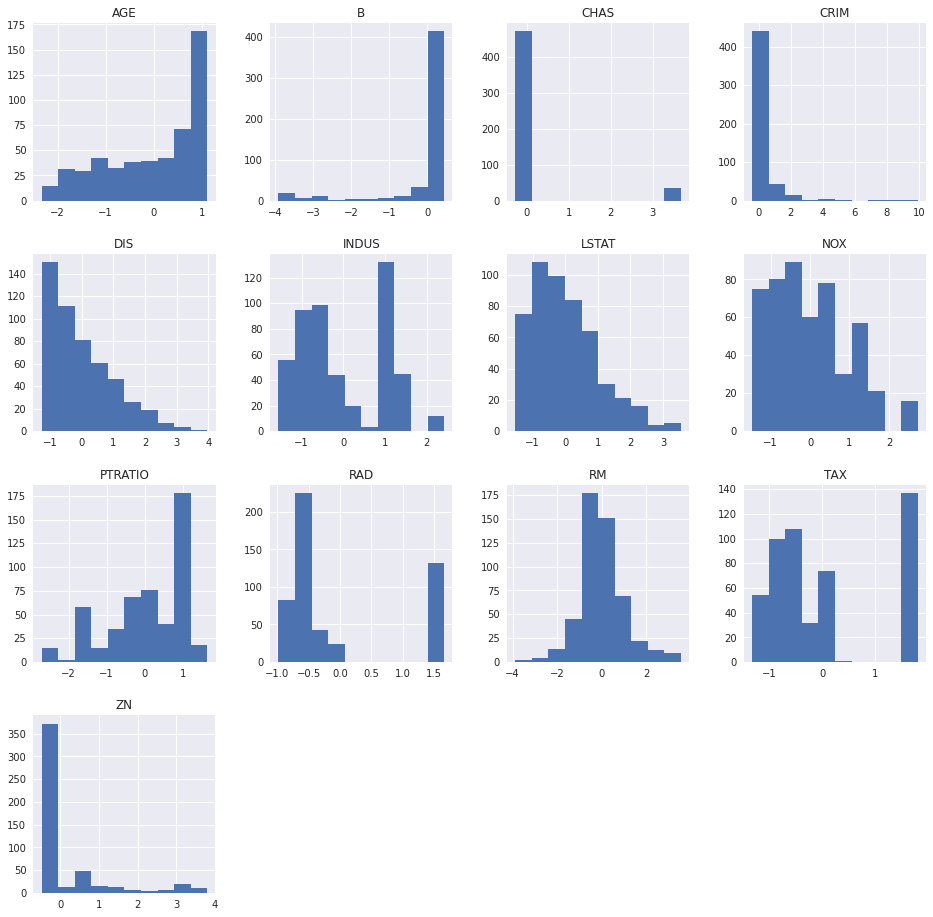

In [37]:
# Histograms for each attribute after pre-processing
X_original[columns_to_scale].hist(layout=(dispRow,dispCol))
plt.show()

In [38]:
# Apply feature scaling techniques

# X_original = X_original.astype(float)
# X_original['some_feature'] = preprocessing.scale(X_original['some_feature'])
# preprocessing.scale(X_original, copy=False)
# X_original['some_feature'] = preprocessing.minmax_scale(X_original['some_feature'])
# preprocessing.minmax_scale(X_original, copy=False)
# X_original['some_feature'] = preprocessing.normalize(X_original['some_feature'])
# preprocessing.normalize(X_original, copy=False)
# X_original['some_feature'] = preprocessing.robust_scale(X_original['some_feature'])
# preprocessing.robust_scale(X_original, copy=False)
# X_original['some_feature'] = preprocessing.power_transform(X_original['some_feature'])
# preprocessing.power_transform(X_original, copy=False)
# print(X_original.head(-10))

In [39]:
# Apply binning techniques with continuous data

# discrete_feature = preprocessing.Binarizer(threshold=0.0)
# feature_binned = discrete_feature.fit_transform(X_original[['old_feature1']])
# X_original['new_feature1'] = feature_binned
# X_original['new_feature1'] = X_original['new_feature1'].astype('category')

# discrete_feature = preprocessing.KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='kmeans')
# feature_binned = discrete_feature.fit_transform(X_original[['old_feature2']])
# X_original['new_feature2'] = feature_binned
# X_original['new_feature2'] = X_original['new_feature2'].astype('category')

# X_original.drop(columns=['old_feature1', 'old_feature2'], inplace=True)
# X_original.head()

### 3.c) Training Data Balancing

In [40]:
# Not applicable for this iteration of the project

In [41]:
# Perform SMOTE transformation on the training data (Block #1 of 2)

# X_train_imbal = X_train_df.values
# y_train_imbal = y_train_df.values.ravel()
# print("X_train_imbal.shape: {} y_train_imbal.shape: {}".format(X_train_imbal.shape, y_train_imbal.shape))

In [42]:
# Perform SMOTE transformation on the training data (Block #2 of 2)

# print ('Original class distribution - 1: {} | 0: {}'.format((y_train_imbal==1).sum(), (y_train_imbal==0).sum()))
# sm = SMOTE(random_state=seedNum, sampling_strategy=1.0)
# X_trainSmote, y_trainSmote = sm.fit_sample(X_train_imbal, y_train_imbal)
# print ('Resampled class distribution - 1: {} | 0: {}'.format((y_train==1).sum(), (y_train==0).sum()))

### 3.d) Feature Selection

In [43]:
# Not applicable for this iteration of the project

In [44]:
# Find collinear features (Block #1 of 3)

# def findCorrelated(corrmat, cutoff = 0.75):    

# ### search correlation matrix and identify pairs that if removed would reduce pair-wise correlations
# # args:
#     # corrmat: a correlation matrix
#     # cutoff: pairwise absolute correlation cutoff
# # returns:
#     # variables to removed

#     if(len(corrmat) != len(corrmat.columns)) : return 'Correlation matrix is not square'
#     averageCorr = corrmat.abs().mean(axis = 1)

#     # set lower triangle and diagonal of correlation matrix to NA
#     for row in range(0, len(corrmat)):
#         for col in range(0, (row+1)):
#             corrmat.iloc[row, col] = None

#     # where a pairwise correlation is greater than the cutoff value, check whether mean abs.corr of a or b is greater and cut it
#     to_delete = list()
#     for col in range(0, len(corrmat.columns)):
#         for row in range(0, len(corrmat)):
#             if(abs(corrmat.iloc[row, col]) > cutoff):
#                 if(averageCorr.iloc[row] > averageCorr.iloc[col]): to_delete.append(row)
#                 else: to_delete.append(col)

#     to_delete = list(set(to_delete))
#     return to_delete

In [45]:
# Find collinear features (Block #2 of 3)

# By using the calculated correlation matrix, find the collinear features
# collinear = findCorrelated(correlations, cutoff = 0.75)
# print('Number of attributes to be removed:', len(collinear))
# dropAttributes = X_train_df.columns[collinear]
# print('Columns to be removed:')
# print(dropAttributes)

In [46]:
# Find collinear features (Block #3 of 3)

# Drop the highly collinear features
# X_train_df.drop(labels=dropAttributes, axis=1, inplace=True)
# X_test_df.drop(labels=dropAttributes, axis=1, inplace=True)

In [47]:
# Perform Attribute Importance Ranking (Block #1 of 3)

# Feature Importance with Gradient Boosting Classifier
# X_impVal = X_train_df.values
# y_impVal = y_train_df.values.ravel()
# model = GradientBoostingClassifier(random_state=seedNum)
# model.fit(X_impVal, y_impVal)
# importanceScore = model.feature_importances_
# attributeList = X_train_df.columns.tolist()
# attributeImportance = pd.DataFrame({'attribute': attributeList, 'importance': importanceScore})
# rankedAttributes = attributeImportance.sort_values('importance', ascending=False)
# print(rankedAttributes)

In [48]:
# Perform Attribute Importance Ranking (Block #2 of 3)

# Set the importance threshold and calculate the list of attributes that don't contribute to the importance threshold
# importanceSum = sum(importanceScore)
# maxThreshold = 0.99
# i = 0
# accumWeight = 0
# exit_now = False
# while ((i < totAttr) and (not exit_now)) :
#     accumWeight = accumWeight + (rankedAttributes.iloc[i]['importance']/importanceSum)
#     if (accumWeight >= maxThreshold) :
#         exit_now = True
#     else :
#         i = i + 1
# print('Number of attributes contributed to the importance threshold:'+str(i))
# lowAttributes = rankedAttributes.iloc[(i):(totAttr),]['attribute'].tolist()
# print('Number of attributes found to be of low importance:',len(lowAttributes))
# print(lowAttributes)

In [49]:
# Perform Attribute Importance Ranking (Block #3 of 3)

# Removing the unselected attributes from the training and validation dataframes
# X_train_df.drop(labels=lowAttributes, axis=1, inplace=True)
# X_test_df.drop(labels=lowAttributes, axis=1, inplace=True)

In [50]:
# Perform Recursive Feature Elimination (Block #1 of 3)

# Using the ensemlbed tree algorithm, we perform the Recursive Feature Elimination (RFE) technique
# X_rfeVal = X_train_df.values
# y_rfeVal = y_train_df.values.ravel()
# estFunc = ExtraTreesClassifier(random_state=seedNum, n_jobs=cpu_num)
# strFold = StratifiedKFold(n_splits=num_folds, random_state=seedNum)
# minFeatures = 10
# selector = RFECV(estimator=estFunc, step=1, min_features_to_select= minFeatures, cv=strFold, scoring=scoring)
# selector = selector.fit(X_rfeVal, y_rfeVal)
# print('The number of selected features:',selector.n_features_)
# print('The mask of selected features:\n',selector.support_)
# print('The ranking of selected features:\n',selector.ranking_)
# plt.figure(figsize=(16,12))
# plt.xlabel("Number of features selected")
# plt.ylabel("Cross validation score")
# plt.plot(range(minFeatures, len(selector.grid_scores_) + minFeatures), selector.grid_scores_)
# plt.show()

In [51]:
# Perform Recursive Feature Elimination (Block #2 of 3)

# Remove the unselected attributes from the training dataframes
# X_train_df = X_train_df[X_train_df.columns[selector.support_]]
# print(X_train_df.shape)
# X_train_df.head()

In [52]:
# Perform Recursive Feature Elimination (Block #3 of 3)

# Remove the unselected attributes from the validation dataframes
# X_test_df = X_test_df[X_test_df.columns[selector.support_]]
# print(X_test_df.shape)
# X_test_df.head()

### 3.e) Display the Final Datasets for Model-Building

In [53]:
# Finalize the training and testing datasets for the modeling activities
X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()
X_test = X_test_df.to_numpy()
y_test = y_test_df.to_numpy()
print("X_train.shape: {} y_train.shape: {}".format(X_train.shape, y_train.shape))
print("X_test.shape: {} y_test.shape: {}".format(X_test.shape, y_test.shape))

X_train.shape: (379, 13) y_train.shape: (379,)
X_test.shape: (127, 13) y_test.shape: (127,)


In [54]:
if notifyStatus: status_notify("Task 3 - Pre-process Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Evaluate Models

In [55]:
if notifyStatus: status_notify("Task 4 - Train and Evaluate Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Set test options and evaluation metric

In [56]:
# Set up Algorithms Spot-Checking Array
startTimeTraining = datetime.now()
startTimeModule = datetime.now()
train_models = []
train_results = []
train_model_names = []
train_metrics = []
train_models.append(('LNR', LinearRegression(n_jobs=n_jobs)))
train_models.append(('RDG', Ridge(random_state=seedNum)))
train_models.append(('LSO', Lasso(random_state=seedNum)))
train_models.append(('ELN', ElasticNet(random_state=seedNum)))
train_models.append(('CART', DecisionTreeRegressor(random_state=seedNum)))
train_models.append(('KNN', KNeighborsRegressor(n_jobs=n_jobs)))
train_models.append(('RNF', RandomForestRegressor(random_state=seedNum, n_jobs=n_jobs)))
train_models.append(('EXT', ExtraTreesRegressor(random_state=seedNum, n_jobs=n_jobs)))
train_models.append(('GBM', GradientBoostingRegressor(random_state=seedNum)))
# train_models.append(('XGB', XGBRegressor(random_state=seedNum, n_jobs=n_jobs, objective='reg:squarederror', tree_method='gpu_hist')))

In [57]:
# Generate model in turn
for name, model in train_models:
	if notifyStatus: status_notify("Algorithm "+name+" modeling has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	startTimeModule = datetime.now()
	kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=n_jobs, verbose=1)
	train_results.append(cv_results)
	train_model_names.append(name)
	train_metrics.append(cv_results.mean())
	print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
	print(model)
	print ('Model training time:', (datetime.now() - startTimeModule), '\n')
	if notifyStatus: status_notify("Algorithm "+name+" modeling completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics ('+scoring+') from all models:',np.mean(train_metrics))
print ('Average RMSE for all models is:', math.sqrt((np.mean(train_metrics)*-1)))
print ('Total training time for all models:',(datetime.now() - startTimeTraining))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


LNR: -27.368626 (9.682484)
LinearRegression(n_jobs=1)
Model training time: 0:00:00.018884 



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


RDG: -27.619045 (9.897511)
Ridge(random_state=888)
Model training time: 0:00:00.019452 



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


LSO: -31.103408 (7.535439)
Lasso(random_state=888)
Model training time: 0:00:00.029044 



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


ELN: -30.646268 (7.137281)
ElasticNet(random_state=888)
Model training time: 0:00:00.027525 



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


CART: -32.162901 (12.390580)
DecisionTreeRegressor(random_state=888)
Model training time: 0:00:00.049710 



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


KNN: -51.228134 (10.279436)
KNeighborsRegressor(n_jobs=1)
Model training time: 0:00:00.035960 



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.7s finished


RNF: -16.100243 (6.296081)
RandomForestRegressor(n_jobs=1, random_state=888)
Model training time: 0:00:03.716644 



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.6s finished


EXT: -14.252497 (6.132694)
ExtraTreesRegressor(n_jobs=1, random_state=888)
Model training time: 0:00:02.559659 



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished


GBM: -13.460023 (3.710129)
GradientBoostingRegressor(random_state=888)
Model training time: 0:00:00.969369 

Average metrics (neg_mean_squared_error) from all models: -27.104571683767297
Average RMSE for all models is: 5.206205113493637
Total training time for all models: 0:00:16.541049


### 4.b) Spot-checking baseline algorithms

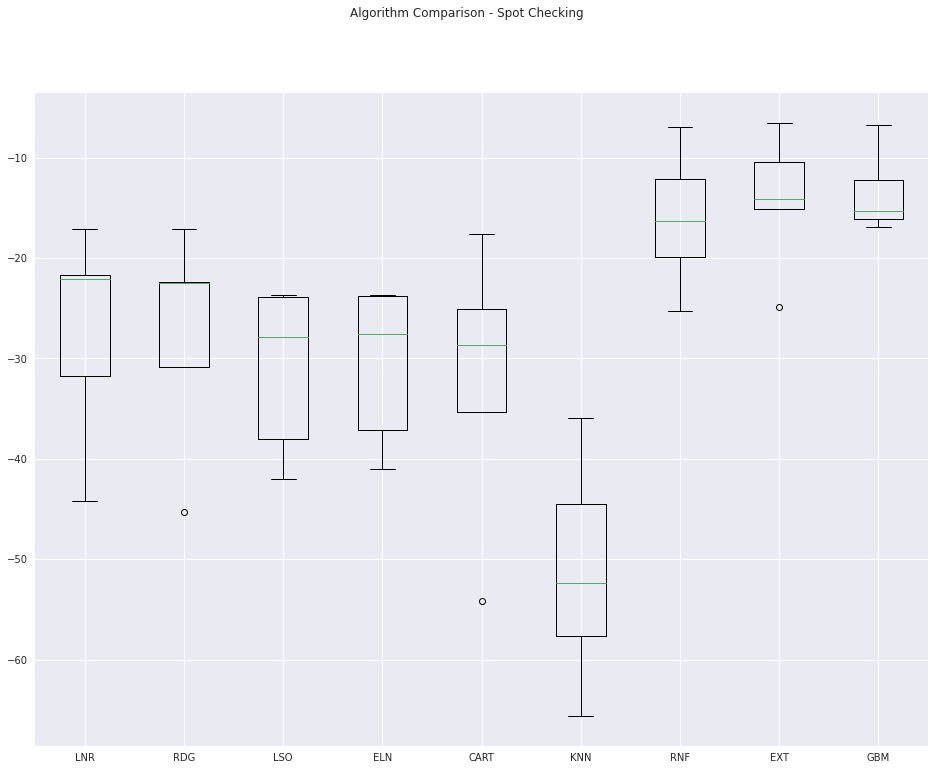

In [58]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
plt.boxplot(train_results)
ax.set_xticklabels(train_model_names)
plt.show()

In [59]:
if notifyStatus: status_notify("Task 4 - Train and Evaluate Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Fine-tune and Improve Models

In [60]:
if notifyStatus: status_notify("Task 5 - Fine-tune and Improve Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Algorithm Tuning

In [61]:
# Set up the comparison array
tune_results = []
tune_model_names = []

In [62]:
# Tuning algorithm #1 - Extra Trees
startTimeModule = datetime.now()
if notifyStatus: status_notify("Algorithm #1 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model1 = ExtraTreesRegressor(random_state=seedNum, n_jobs=n_jobs)
paramGrid1 = dict(n_estimators=np.array([100, 150, 200, 250, 300]))
tune_model_names.append('EXT')

kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=scoring, cv=kfold, n_jobs=n_jobs, verbose=1)
grid_result1 = grid1.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Best RMSE for the Model is:', math.sqrt((grid_result1.best_score_*-1)))
print ('Model training time:',(datetime.now() - startTimeModule))
if notifyStatus: status_notify("Algorithm #1 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   25.4s finished


Best: -14.057953 using {'n_estimators': 200}
-14.252497 (6.132694) with: {'n_estimators': 100}
-14.231935 (5.708315) with: {'n_estimators': 150}
-14.057953 (5.803851) with: {'n_estimators': 200}
-14.196196 (5.881080) with: {'n_estimators': 250}
-14.143508 (5.819458) with: {'n_estimators': 300}
Best RMSE for the Model is: 3.749393624235276
Model training time: 0:00:27.013519


In [63]:
best_paramKey1 = list(grid_result1.best_params_.keys())[0]
best_paramValue1 = list(grid_result1.best_params_.values())[0]
print("Captured the best parameter for algorithm #1:", best_paramKey1, '=', best_paramValue1)

Captured the best parameter for algorithm #1: n_estimators = 200


In [64]:
# Tuning algorithm #2 - Gradient Boosting
startTimeModule = datetime.now()
if notifyStatus: status_notify("Algorithm #2 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model_names.append('GBM')
tune_model2 = GradientBoostingRegressor(random_state=seedNum)
paramGrid2 = dict(n_estimators=np.array([50,75,100,125,150]))

kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
grid2 = GridSearchCV(estimator=tune_model2, param_grid=paramGrid2, scoring=scoring, cv=kfold, n_jobs=n_jobs, verbose=1)
grid_result2 = grid2.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
tune_results.append(grid_result2.cv_results_['mean_test_score'])
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Best RMSE for the Model is:', math.sqrt((grid_result2.best_score_*-1)))
print ('Model training time:',(datetime.now() - startTimeModule))
if notifyStatus: status_notify("Algorithm #2 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    4.9s finished


Best: -13.356254 using {'n_estimators': 125}
-13.620535 (3.707170) with: {'n_estimators': 50}
-13.451273 (3.752099) with: {'n_estimators': 75}
-13.460023 (3.710129) with: {'n_estimators': 100}
-13.356254 (3.706421) with: {'n_estimators': 125}
-13.434488 (3.672188) with: {'n_estimators': 150}
Best RMSE for the Model is: 3.654620935321807
Model training time: 0:00:05.662947


In [65]:
best_paramKey2 = list(grid_result2.best_params_.keys())[0]
best_paramValue2 = list(grid_result2.best_params_.values())[0]
print("Captured the best parameter for algorithm #2:", best_paramKey2, '=', best_paramValue2)

Captured the best parameter for algorithm #2: n_estimators = 125


### 5.b) Compare Algorithms After Tuning

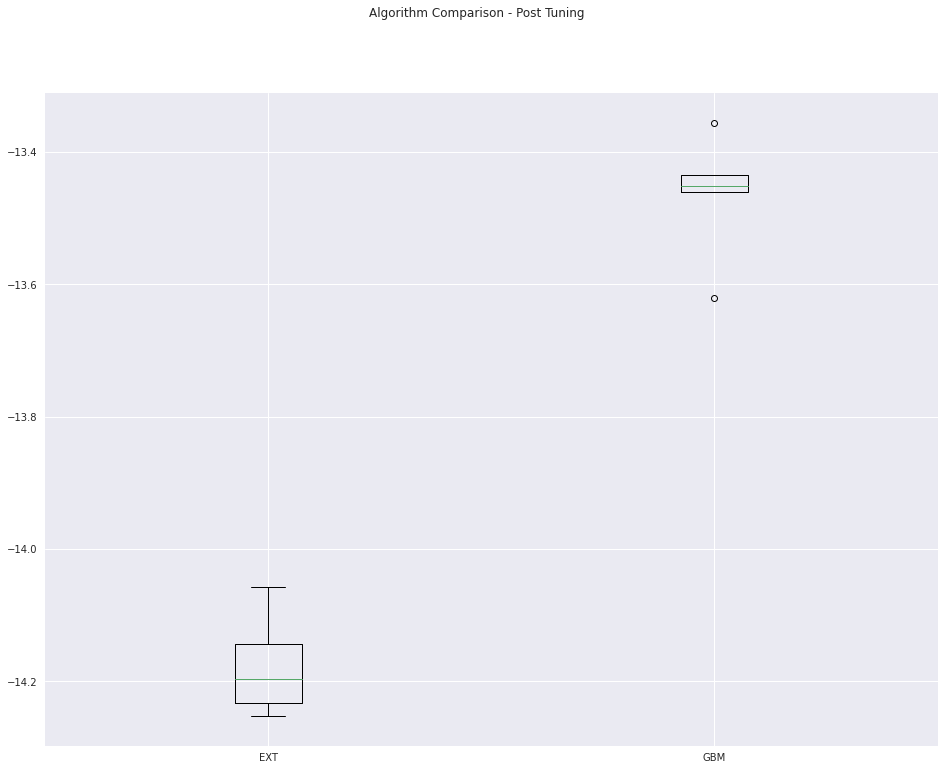

In [66]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(tune_results)
ax.set_xticklabels(tune_model_names)
plt.show()

In [67]:
if notifyStatus: status_notify("Task 5 - Fine-tune and Improve Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 6 - Finalize Model and Present Analysis

In [68]:
if notifyStatus: status_notify("Task 6 - Finalize Model and Present Analysis has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 6.a) Measure predictions from the test dataset

In [69]:
test_model1 = ExtraTreesRegressor(n_estimators=best_paramValue1, random_state=seedNum, n_jobs=n_jobs)
test_model1.fit(X_train, y_train)
predictions1 = test_model1.predict(X_test)
print('RMSE for the model is: ', math.sqrt(mean_squared_error(y_test, predictions1)))
print('R2 for the model is: ', r2_score(y_test, predictions1))
print(test_model1)

RMSE for the model is:  2.449096502215737
R2 for the model is:  0.9167976297391319
ExtraTreesRegressor(n_estimators=200, n_jobs=1, random_state=888)


In [70]:
test_model2 = GradientBoostingRegressor(n_estimators=best_paramValue2, random_state=seedNum)
test_model2.fit(X_train, y_train)
predictions2 = test_model2.predict(X_test)
print('RMSE for the model is: ', math.sqrt(mean_squared_error(y_test, predictions2)))
print('R2 for the model is: ', r2_score(y_test, predictions2))
print(test_model2)

RMSE for the model is:  2.3820600945896455
R2 for the model is:  0.9212901055823304
GradientBoostingRegressor(n_estimators=125, random_state=888)


### 6.b) Create a standalone model using all available data

In [71]:
# Combining the training and testing datasets to form the complete dataset that will be used for training the final model
# X_complete = np.vstack((X_train, X_test))
# y_complete = np.concatenate((y_train, y_test))
# print("X_complete.shape: {} y_complete.shape: {}".format(X_complete.shape, y_complete.shape))
# final_model = test_model1.fit(X_complete, y_complete)
# print(final_model)

### 6.c) Save the final model for later use

In [72]:
# modelName = 'FinalModel_Regression.sav'
# dump(final_model, modelName)

In [73]:
if notifyStatus: status_notify("Task 6 - Finalize Model and Present Analysis completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [74]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:01:25.165579
